In [4]:
# Import the necessary tqdm versions
from tqdm.notebook import tqdm as ntqdm
import sys

# Monkey-patch tqdm
sys.modules['tqdm.tqdm'] = ntqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datasets import load_dataset, load
from huggingface_hub import hf_hub_download, snapshot_download



from pymicro.crystal.ebsd import OimScan
from pymicro.crystal.lattice import Lattice, CrystallinePhase, Symmetry
from pymicro.crystal.microstructure import Microstructure
from pymicro.crystal.quaternion import Quaternion
from tqdm.notebook import tqdm



## Download raw EBSD scans (.ctf)

In [ ]:
snapshot_download(repo_id="Rxzh/EBSD-scans", allow_patterns="*.ctf",repo_type="dataset",local_dir='data/')

## Generate orientation maps

In [3]:
epsilon = np.finfo('float').eps


def up_axis(axis):
    if abs(axis[2]) > epsilon:
        if axis[2] < 0.:
            # reverse axis
            return -1. * axis
    elif abs(axis[1]) > epsilon:
        if axis[1] < 0:
            # reverse axis and zero z component
            return np.array([-axis[0], -axis[1], 0.])
    elif axis[0] < 0.:
        # reverse axis and zero y and z components
        return np.array([-axis[0], 0., 0.])
    return axis


def get_quats(scan):
    eulers = np.reshape(scan.euler, (np.prod(scan.iq.shape), 3))
    scan.quats = np.empty((list(scan.iq.shape) + [4]), float)
    print(eulers.shape)
    phi1, Phi, phi2 = np.squeeze(np.split(eulers, 3, axis=1))
    q0 = np.cos(0.5 * (phi1 + phi2)) * np.cos(0.5 * Phi)
    q1 = np.cos(0.5 * (phi1 - phi2)) * np.sin(0.5 * Phi)
    q2 = np.sin(0.5 * (phi1 - phi2)) * np.sin(0.5 * Phi)
    q3 = np.sin(0.5 * (phi1 + phi2)) * np.cos(0.5 * Phi)
    quats = np.array([q0, q1, q2, q3]).T
    # the scalar part must be positive
    quats = quats * np.sign(q0).reshape([-1, 1])
    # handle ambiguous rotation
    ambig = np.where(quats[:, 0] < 3 * epsilon)[0]
    for i in ambig:
        axis = up_axis(quats[i, 1:])
        quats[i] = np.array([0., *axis])
    quats = quats.reshape(scan.quats.shape)
    print(quats.shape)

    return quats

In [ ]:
if not(os.path.exists('data/quat_ebsd_maps/')): os.mkdir('data/quat_ebsd_maps/')
    
for fname in os.listdir('data/raw_ebsd_scans/'):
    scan = OimScan.from_file(os.path.join('data/raw_ebsd_scans/',fname),use_spatial_ref_frame=True )
    quats = get_quats(scan)
    np.save(os.path.join('data/quat_ebsd_maps/',fname.replace('.ctf','.npy')), quats)



## Generate grains ids maps

In [ ]:
if not(os.path.exists('data/grains_ids_maps/')): os.mkdir('data/grains_ids_maps/')
    
for fname in tqdm(os.listdir('data/raw_ebsd_scans/')):
    scan = OimScan.from_file(os.path.join('data/raw_ebsd_scans/',fname),use_spatial_ref_frame=True )
    grains_map = scan.segment_grains(tol=5., min_ci=-0.1)
    np.save(os.path.join('data/grains_ids_maps/',fname.replace('.ctf','.npy')), grains_map)

# Compute mean orientation maps

In [ ]:
if not(os.path.exists('data/mean_quats_maps/')): os.mkdir('data/mean_quats_maps/')
    
for fname in tqdm(os.listdir('data/quat_ebsd_maps/')):
    if os.path.exists(os.path.join('data/mean_quats_maps/',fname,)):
        continue

    # load the segmentation
    grain_ids = np.squeeze(np.load(os.path.join('data/grains_ids_maps',fname)))
    
    # directly import the EBSD data, here we chose not to take the confidence index into account
    m = Microstructure.from_ebsd(os.path.join('data/raw_ebsd_scans',fname.replace('.npy','.ctf')),  grain_ids=grain_ids)

    m.quats = np.load(os.path.join('data/quat_ebsd_maps', fname))

    mean_quats_map = np.zeros_like(m.quats)
    for gid in tqdm(np.unique(grain_ids)):
        quats_gid = m.quats[np.where(grain_ids == gid)]
        mean_quat = np.mean(quats_gid, axis=0)
        mean_quat /= np.sqrt(np.sum(mean_quat ** 2))
        mean_quats_map[np.where(grain_ids == gid)] = mean_quat
    
    np.save(os.path.join('data/mean_quats_maps/',fname), mean_quats_map)


if not(os.path.exists('data/mean_quats_maps_no_twins/')): os.mkdir('data/mean_quats_maps_no_twins/')
    
for fname in tqdm(os.listdir('data/quat_ebsd_maps/')):
    if os.path.exists(os.path.join('data/mean_quats_maps_no_twins/',fname,)):
        print('mean exists for: ', fname)
        continue

    if not(os.path.exists(os.path.join('data/grains_no_twins_ids_maps/',fname.replace('.npy','_refined.npy')))):
        print('refined not found for: ', fname)
        continue
    # load the segmentation
    grain_ids = np.squeeze(np.load(os.path.join('data/grains_no_twins_ids_maps/',fname.replace('.npy','_refined.npy'))))
    
    # directly import the EBSD data, here we chose not to take the confidence index into account
    m = Microstructure.from_ebsd(os.path.join('data/raw_ebsd_scans',fname.replace('.npy','.ctf')),  grain_ids=grain_ids)

    m.quats = np.load(os.path.join('data/quat_ebsd_maps', fname))

    mean_quats_map = np.zeros_like(m.quats)
    for gid in tqdm(np.unique(grain_ids)):
        quats_gid = m.quats[np.where(grain_ids == gid)]
        mean_quat = np.mean(quats_gid, axis=0)
        mean_quat /= np.sqrt(np.sum(mean_quat ** 2))
        mean_quats_map[np.where(grain_ids == gid)] = mean_quat
    
    np.save(os.path.join('data/mean_quats_maps_no_twins/',fname), mean_quats_map)



# Create the tiles dataset

In [ ]:
def create_tiles(image, tile_size):
    # Get the dimensions of the image
    height, width, c = image.shape

    # Calculate the number of tiles in each dimension
    num_tiles_x = width // tile_size
    num_tiles_y = height // tile_size

    # Initialize a list to hold the tiles
    tiles = []

    # Loop over the image and extract tiles
    for y in range(num_tiles_y):
        for x in range(num_tiles_x):
            # Extract the tile
            tile = image[y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size, :]
            np.nan_to_num(tile, nan=0.0, posinf=None, neginf=None)
            tiles.append(tile)

    return tiles

In [ ]:
!ls data/mean_quats_maps_no_twins/

In [ ]:
!ls data

In [ ]:
if not os.path.exists('data/tiles/'): os.mkdir('data/tiles')
if not os.path.exists('data/tiles/raw'): os.mkdir('data/tiles/raw')
if not os.path.exists('data/tiles/mean'): os.mkdir('data/tiles/mean')

In [ ]:
train_val_fnames = ['19-B588.npy'    ,
                     '19-B589.npy',
                     '19-B591.npy',
                    'ERC_IN718_20210723 Specimen indent Site 2 Map Data 3.npy',
                    'ERC_IN718_25h_5h_1080C 5_4 Site 1 Map Data 14.npy',
                    'IN718_NEWTEC Nanoindentation 5min Nano-5m Site 1 Map Data 5_clean.npy']

test_fnames = ['19-B590.npy']



In [ ]:
dataset = pd.DataFrame()

for fname in train_val_fnames:
    print('File: {}'.format(fname))
    x_mean = np.load(os.path.join('data/mean_quats_maps/', fname))
    x_raw = np.load(os.path.join('data/quat_ebsd_maps/', fname))
    
    tiles_mean = create_tiles(x_mean, tile_size=128)
    tiles_raw = create_tiles(x_raw, tile_size=128)
    
    for idx, tile_mean in enumerate(np.array(tiles_mean)[:,:,:,0]):
        n_grains = len(np.unique(tile_mean))
        tile_idx = len(os.listdir('data/tiles/raw/'))

        np.save(f'data/tiles/raw/tile_{tile_idx}.npy',  tiles_raw[idx])
        np.save(f'data/tiles/mean/tile_{tile_idx}.npy', tiles_mean[idx])
        dataset = pd.concat([dataset, pd.DataFrame([int(tile_idx), int(n_grains)]).T])

    print('======================================================')
dataset.columns = ['tile_idx', 'n_grains']
dataset.set_index('tile_idx', inplace=True)

In [ ]:
plt.hist(dataset['n_grains'], bins=100)
plt.show()

In [ ]:
dataset.sort_values('n_grains', ascending=False).head(5)

In [ ]:
plt.imshow(np.load('data/tiles/raw/tile_425.npy')[:,:,0])

In [ ]:
plt.imshow(np.load('data/tiles/raw/tile_12.npy')[:,:,0])

In [ ]:
dataset.loc[dataset['n_grains']>50,'train_or_val'] = 'train'

In [ ]:
df=dataset[dataset.isna()['train_or_val']]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df['n_grains_binned'] = pd.qcut(df['n_grains'], q=4, duplicates='drop')  # Adjust q based on your needs

# Perform the train-test split
X_train, X_test = train_test_split(
    df.index,  # Features
    test_size=0.2,  # 20% test size
    random_state=42,
    stratify=df['n_grains_binned']  # Stratify based on the binned variable
)

In [ ]:


dataset.loc[X_train, 'train_or_val'] = 'train'
dataset.loc[X_test, 'train_or_val'] = 'val'

In [ ]:
plt.hist(dataset[dataset['train_or_val']=='train']['n_grains'], bins=100)
plt.xlabel('Grain size')
plt.ylabel('Count')
plt.show()

In [ ]:
plt.hist(dataset[dataset['train_or_val']=='val']['n_grains'], bins=50)
plt.xlabel('Grain size')
plt.ylabel('Count')
plt.show()

In [ ]:
dataset

In [ ]:
import shutil

In [ ]:
for dirname in ['data/tiles/mean/train/', 
                'data/tiles/mean/val/',
                'data/tiles/raw/train/',
                'data/tiles/raw/val/',
                'data/tiles/raw/test/',
                'data/tiles/mean/test/',]:
    if not os.path.exists(dirname): os.mkdir(dirname)

In [ ]:
for i in dataset.index:
    if dataset.loc[i,'train_or_val'] == 'train':
        shutil.copy(f'data/tiles/mean/tile_{i}.npy', f'data/tiles/mean/train/tile_{i}.npy')
        shutil.copy(f'data/tiles/raw/tile_{i}.npy', f'data/tiles/raw/train/tile_{i}.npy')
    else:
        shutil.copy(f'data/tiles/mean/tile_{i}.npy', f'data/tiles/mean/val/tile_{i}.npy')
        shutil.copy(f'data/tiles/raw/tile_{i}.npy', f'data/tiles/raw/val/tile_{i}.npy')

In [ ]:
for root, dirs, files in os.walk('data/tiles/mean'):
    print(root)

In [ ]:
for fname in test_fnames:
    print('File: {}'.format(fname))
    x_mean = np.load(os.path.join('data/mean_quats_maps/', fname))
    x_raw = np.load(os.path.join('data/quat_ebsd_maps/', fname))
    
    tiles_mean = create_tiles(x_mean, tile_size=128)
    tiles_raw = create_tiles(x_raw, tile_size=128)
    
    for idx, tile_mean in enumerate(np.array(tiles_mean)[:,:,:,0]):
        n_grains = len(np.unique(tile_mean))
        tile_idx = len(os.listdir('data/tiles/raw/test/'))

        np.save(f'data/tiles/raw/test/test_tile_{tile_idx}.npy',  tiles_raw[idx])
        np.save(f'data/tiles/mean/test/test_tile_{tile_idx}.npy', tiles_mean[idx])


## Tiles dataset augmentation

In [ ]:
for dirname in ['data/tiles_aug/',
                'data/tiles_aug/mean/',
                'data/tiles_aug/mean_no_twins/',
                'data/tiles_aug/raw/',
                'data/tiles_aug/mean/train/', 
                'data/tiles_aug/mean/val/',
                'data/tiles_aug/mean_no_twins/train/', 
                'data/tiles_aug/mean_no_twins/val/',
                'data/tiles_aug/raw/train/',
                'data/tiles_aug/raw/val/',
                'data/tiles_aug/raw/test/',
                'data/tiles_aug/mean/test/',
               'data/tiles_aug/mean_no_twins/test/',]:
    if not os.path.exists(dirname): os.mkdir(dirname)

In [ ]:
train_val_fnames = ['19-B588.npy',
                     '19-B589.npy',
                     '19-B591.npy',
                    'ERC_IN718_20210723 Specimen indent Site 2 Map Data 3.npy',
                    'ERC_IN718_25h_5h_1080C 5_4 Site 1 Map Data 14.npy',
                    'IN718_NEWTEC Nanoindentation 5min Nano-5m Site 1 Map Data 5_clean.npy']

test_fnames = ['19-B590.npy']


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
from skimage.util import view_as_windows

def calculate_histogram(tile, num_bins=50):
    """Calculate a normalized histogram for a tile."""
    bins = np.linspace(-1, 1, num_bins + 1)  # Bins for normalized values
    hist = [np.histogram(tile[:, :, i], bins=bins)[0] for i in range(4)]
    hist = np.concatenate(hist) / np.sum(hist)  # Normalize
    return hist

def calculate_diversity(tiles):
    """Calculate the diversity of a set of tiles as the sum of pairwise distances."""
    histograms = np.array([calculate_histogram(tile) for tile in tiles])
    distances = cdist(histograms, histograms, metric='euclidean')
    return np.sum(distances)

def extract_diverse_tiles(image_mean,image_raw, tile_size, n_tiles):
    stride = 8  # Adjust stride if needed
    tiles_mean = view_as_windows(image_mean, (tile_size, tile_size, 4), step=stride)
    tiles_mean = tiles_mean.reshape(-1, tile_size, tile_size, 4)

    tiles_raw = view_as_windows(image_raw, (tile_size, tile_size, 4), step=stride)
    tiles_raw = tiles_raw.reshape(-1, tile_size, tile_size, 4)
    
    selected_tiles_mean = []
    selected_tiles_raw = []
    remaining_tiles_raw=  list(tiles_raw)
    del tiles_raw
    remaining_tiles_mean = list(tiles_mean)
    del tiles_mean
    
    # Greedy selection to maximize set diversity
    print(f"generating {n_tiles} tiles ...")
    for _ in tqdm(range(n_tiles)):
        max_diversity = 0
        best_tile_index = None
        
        for index, tile in enumerate(remaining_tiles_raw):
            temp_set = selected_tiles_raw + [tile]
            diversity = calculate_diversity(temp_set)
            
            if diversity >= max_diversity:
                max_diversity = diversity
                best_tile_index = index
        
        if best_tile_index is not None:
            selected_tiles_raw.append(remaining_tiles_raw[best_tile_index])
            remaining_tiles_raw.pop(best_tile_index)  # Use pop to remove by index
            selected_tiles_mean.append(remaining_tiles_mean[best_tile_index])
            remaining_tiles_mean.pop(best_tile_index)  # Use pop to remove by index
    
    return selected_tiles_raw, selected_tiles_mean

# Example usage assuming `image` is an np.array of shape (H, W, 4)
# diverse_tiles = extract_diverse_tiles(image, m, n)


In [ ]:
augmentation_factor = 10
tile_size = 128

# Prepare the CSV file to store the results
csv_file_path = 'temp.csv'
# Create the CSV with the header if it doesn't exist
if not os.path.exists(csv_file_path):
    with open(csv_file_path, 'w') as file:
        file.write('tile_idx,n_grains\n')

for fname in tqdm(train_val_fnames):
    print('File: {}'.format(fname))
    x_mean = np.load(os.path.join('data/mean_quats_maps/', fname))
    x_raw = np.load(os.path.join('data/quat_ebsd_maps/', fname))
    x_mean_no_twins = np.load(os.path.join('data/mean_quats_maps_no_twins/', fname))
    
    # Calculate the step size for the window based on the augmentation factor
    step_size = tile_size // (augmentation_factor // 2)
    
    tiles_raw = view_as_windows(x_raw, (tile_size, tile_size, 4), step=step_size).reshape(-1, tile_size, tile_size, 4)
    tiles_mean = view_as_windows(x_mean, (tile_size, tile_size, 4), step=step_size).reshape(-1, tile_size, tile_size, 4)
    tiles_mean_no_twins = view_as_windows(x_mean_no_twins, (tile_size, tile_size, 4), step=step_size).reshape(-1, tile_size, tile_size, 4)

    print(len(tiles_raw))
    
    for idx, tile_mean in enumerate(tiles_mean[:,:,:,0]):
        n_grains = len(np.unique(tile_mean))
        tile_idx = len(os.listdir('data/tiles_aug/raw/'))

        # Save the tile data
        np.save(f'data/tiles_aug/raw/tile_{tile_idx}.npy',  tiles_raw[idx])
        np.save(f'data/tiles_aug/mean/tile_{tile_idx}.npy', tiles_mean[idx])
        np.save(f'data/tiles_aug/mean_no_twins/tile_{tile_idx}.npy', tiles_mean_no_twins[idx])
        
        # Append the new line to the CSV
        with open(csv_file_path, 'a') as file:
            file.write(f'{tile_idx},{n_grains}\n')

    print('======================================================')


In [ ]:
dataset_aug = pd.DataFrame()

augmentation_factor = 9

for fname in tqdm(train_val_fnames):
    print('File: {}'.format(fname))
    x_mean = np.load(os.path.join('data/mean_quats_maps/', fname))
    x_raw = np.load(os.path.join('data/quat_ebsd_maps/', fname))
    x_mean_no_twins = np.load(os.path.join('data/mean_quats_maps_no_twins/', fname))
    
    n_tiles = int(len(create_tiles(x_mean, tile_size=128))*augmentation_factor)
    tile_size=128
    #tiles_raw = create_tiles(x_raw, tile_size=128)

    #tiles_raw,tiles_mean = extract_diverse_tiles(x_mean,x_raw, tile_size=128, n_tiles=n_tiles)
    #print(len(tiles_raw))
    
    tiles_raw = view_as_windows(x_raw, (tile_size, tile_size, 4), step=tile_size//(augmentation_factor//2)).reshape(-1, tile_size, tile_size, 4)
    tiles_mean = view_as_windows(x_mean, (tile_size, tile_size, 4), step=tile_size//(augmentation_factor//2)).reshape(-1, tile_size, tile_size, 4)
    tiles_mean_no_twins = view_as_windows(x_mean_no_twins, (tile_size, tile_size, 4), step=tile_size//(augmentation_factor//2)).reshape(-1, tile_size, tile_size, 4)

    print(len(tiles_raw))
    
    for idx, tile_mean in enumerate(np.array(tiles_mean)[:,:,:,0]):
        n_grains = len(np.unique(tile_mean))
        tile_idx = len(os.listdir('data/tiles_aug/raw/'))

        np.save(f'data/tiles_aug/raw/tile_{tile_idx}.npy',  tiles_raw[idx])
        np.save(f'data/tiles_aug/mean/tile_{tile_idx}.npy', tiles_mean[idx])
        np.save(f'data/tiles_aug/mean_no_twins/tile_{tile_idx}.npy', tiles_mean_no_twins[idx])
        dataset_aug = pd.concat([dataset_aug, pd.DataFrame([int(tile_idx), int(n_grains)]).T])

    print('======================================================')
dataset_aug.columns = ['tile_idx', 'n_grains']
dataset_aug.set_index('tile_idx', inplace=True)

In [ ]:
dataset_aug = pd.read_csv('temp.csv')

In [ ]:
dataset_aug.loc[dataset_aug['n_grains']>50,'train_or_val'] = 'train'

In [ ]:

df=dataset_aug[dataset_aug.isna()['train_or_val']]

df['n_grains_binned'] = pd.qcut(df['n_grains'], q=4, duplicates='drop')  # Adjust q based on your needs



In [ ]:
# Perform the train-test split
X_train, X_test = train_test_split(
    df.index,  # Features
    test_size=0.2,  # 20% test size
    random_state=42,
    stratify=df['n_grains_binned']  # Stratify based on the binned variable
)

dataset_aug.loc[X_train, 'train_or_val'] = 'train'
dataset_aug.loc[X_test, 'train_or_val'] = 'val'

In [ ]:
dataset_aug['train_or_val'].unique()

In [ ]:
import shutil

In [ ]:
dataset_aug.set_index('tile_idx', inplace=True)

In [ ]:
for i in dataset_aug.index:
    if dataset_aug.loc[i,'train_or_val'] == 'train':
        shutil.move(f'data/tiles_aug/mean/tile_{i}.npy', f'data/tiles_aug/mean/train/tile_{i}.npy')
        shutil.move(f'data/tiles_aug/mean_no_twins/tile_{i}.npy', f'data/tiles_aug/mean_no_twins/train/tile_{i}.npy')
        shutil.move(f'data/tiles_aug/raw/tile_{i}.npy', f'data/tiles_aug/raw/train/tile_{i}.npy')
        
    else:
        shutil.move(f'data/tiles_aug/mean/tile_{i}.npy', f'data/tiles_aug/mean/val/tile_{i}.npy')
        shutil.move(f'data/tiles_aug/mean_no_twins/tile_{i}.npy', f'data/tiles_aug/mean_no_twins/val/tile_{i}.npy')
        shutil.move(f'data/tiles_aug/raw/tile_{i}.npy', f'data/tiles_aug/raw/val/tile_{i}.npy')

In [ ]:
for fname in test_fnames:
    print('File: {}'.format(fname))
    x_mean = np.load(os.path.join('data/mean_quats_maps/', fname))
    x_mean_no_twins = np.load(os.path.join('data/mean_quats_maps_no_twins/', fname))
    x_raw = np.load(os.path.join('data/quat_ebsd_maps/', fname))
    
    tiles_mean = create_tiles(x_mean, tile_size=128)
    tiles_mean_no_twins = create_tiles(x_mean_no_twins, tile_size=128)
    tiles_raw = create_tiles(x_raw, tile_size=128)
    
    for idx, tile_mean in enumerate(np.array(tiles_mean)[:,:,:,0]):
        n_grains = len(np.unique(tile_mean))
        tile_idx = len(os.listdir('data/tiles_aug/raw/test/'))

        np.save(f'data/tiles_aug/raw/test/test_tile_{tile_idx}.npy',  tiles_raw[idx])
        np.save(f'data/tiles_aug/mean/test/test_tile_{tile_idx}.npy', tiles_mean[idx])
        np.save(f'data/tiles_aug/mean_no_twins/test/test_tile_{tile_idx}.npy', tiles_mean_no_twins[idx])



# Remove the twins

In [5]:
def find(parent, i):
    if parent[i] == i:
        return i
    else:
        # Path compression heuristic
        parent[i] = find(parent, parent[i])
        return parent[i]

def union(parent, size, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)
    
    if xroot != yroot:
        # Always attach the smaller tree to the larger tree based on size
        if size[xroot] < size[yroot]:
            parent[xroot] = yroot
            size[yroot] += size[xroot]
        else:
            parent[yroot] = xroot
            size[xroot] += size[yroot]

def merge_twins(twins_pairs, grains_ids):
    parent = {}
    size = {}

    # Extract unique grain IDs from the 2D grains_ids map
    unique_grains = np.unique(grains_ids)

    # Initialize the parent and size for each unique grain ID
    for grain_id in unique_grains:
        parent[grain_id] = grain_id
        size[grain_id] = np.sum(grains_ids == grain_id)

    # Process each pair and union the sets
    for grain_id, neighbor_id in twins_pairs:
        union(parent, size, grain_id, neighbor_id)

    # Create a new grains_ids map by updating each pixel to its representative
    new_grains_ids_map = np.copy(grains_ids)
    for i in range(new_grains_ids_map.shape[0]):
        for j in range(new_grains_ids_map.shape[1]):
            new_grains_ids_map[i, j] = find(parent, new_grains_ids_map[i, j])

    return new_grains_ids_map

In [6]:
def are_twins(m, grain1_id, grain2_id):
    # Constants
    nu_0 = 15  # degrees
    Sigma = 3  # Sigma value for twinning, typically 3 for {111} in FCC

    # Compute the Brandon criterion tolerance
    nu_mis = nu_0 / np.sqrt(Sigma)

    # Retrieve orientation matrices for both grains
    grain1 = m.get_grain(grain1_id)
    grain2 = m.get_grain(grain2_id)

    # Compute disorientation
    disorientation_angle, mis_axis, _ = Orientation(m.get_grain(grain1_id).orientation_matrix()).disorientation(
        m.get_grain(grain2_id).orientation, crystal_structure=Symmetry.cubic
    )

    # Convert disorientation angle from radians to degrees
    theta_Sigma = np.degrees(disorientation_angle)

    # Twinning misorientation angle for {111} in FCC (60 degrees)
    theta_mis = 60

    # Check using Brandon criterion for the angle
    if abs(theta_Sigma - theta_mis) > nu_mis:
        return False

    # Check if the misorientation axis is close to the <111> direction
    axis_111 = np.array([1, 1, 1]) / np.sqrt(3)  # normalized <111> axis
    axis_111_neg = -axis_111  # also consider the negative direction

    # Check if the misorientation axis is close to the <111> axis or its negative
    axis_match = np.allclose(mis_axis, axis_111, atol=0.1) or np.allclose(mis_axis, axis_111_neg, atol=0.1)

    return axis_match

In [ ]:
if not os.path.exists('data/grains_no_twins_ids_maps'):
    os.mkdir('data/grains_no_twins_ids_maps')

for fname in tqdm(os.listdir('data/quat_ebsd_maps/')):
    if os.path.exists(os.path.join('data/grains_no_twins_ids_maps', fname)):
        continue

    # load the segmentation
    grain_ids = np.squeeze(np.load(os.path.join('data/grains_ids_maps',fname)))
    
    # directly import the EBSD data, here we chose not to take the confidence index into account
    m = Microstructure.from_ebsd(os.path.join('data/raw_ebsd_scans',fname.replace('.npy','.ctf')),  grain_ids=grain_ids)
    m.dilate_grains(dilation_steps=3, new_map_name='grain_map', update_microstructure_properties=True)

    m.quats = np.load(os.path.join('data/quat_ebsd_maps', fname))

    print('Searching for twins...')
    twins_pairs=[]
    for grain in tqdm(m.grains):
        grain_id=grain['idnumber']
        if not(grain_id==0):
            for neighbor_id in m.find_neighbors(grain_id):
                if not(neighbor_id==0):
                    if are_twins(m, grain_id, neighbor_id):
                        #print('grain: {} and neighbor: {} are twins'.format(grain_id, neighbor_id))
                        twins_pairs.append([grain_id, neighbor_id])

    new_grain_ids = merge_twins(twins_pairs,grain_ids)

    np.save(os.path.join('data/grains_no_twins_ids_maps', fname), new_grain_ids)

  0%|          | 0/7 [00:00<?, ?it/s]

0 phases found in the data set
new phase added: unknown
ERC_IN718_20210723 Specimen indent Site 2 Map Data 3 .ctf
using ref_frame 4
symmetry was changed to Symmetry.cubic
adding phase Phase 1 (Ni-superalloy) 
	-- Lattice (Symmetry.cubic) a=0.357, b=0.357, c=0.357 alpha=90.0, beta=90.0, gamma=90.0
adding phase Phase 2 (Delta Ni3Nb56) 
	-- Lattice (Symmetry.orthorhombic) a=0.514, b=0.423, c=0.453 alpha=90.0, beta=90.0, gamma=90.0
importing data from region [0, 1978, 0, 1360]
using spatial reference frame for orientation data



changing orientation reference frame progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2677745/2677745 [02:23<00:00, 18722.90it/s]




0 phases found in the data set
new phase added: Ni-superalloy
new phase added: Delta Ni3Nb56
using existing segmentation containing 748 grains, size is  (1978, 1360)






creating new grains: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 748/748 [29:13<00:00,  2.34s/it]


computing grains geometry
12275 voxels to replace
dilation step 1 done
58 voxels to replace
dilation step 2 done
2 voxels to replace
dilation step 3 done




updating phase map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:12<00:00, 61.68it/s]


Searching for twins...


  0%|          | 0/747 [00:00<?, ?it/s]

0 phases found in the data set
new phase added: unknown
19-B590 .ctf
using ref_frame 4
symmetry was changed to Symmetry.cubic
adding phase Phase 1 (Ni-superalloy) 
	-- Lattice (Symmetry.cubic) a=0.357, b=0.357, c=0.357 alpha=90.0, beta=90.0, gamma=90.0
importing data from region [0, 500, 0, 1000]
using spatial reference frame for orientation data



changing orientation reference frame progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 496023/496023 [00:26<00:00, 18605.98it/s]




0 phases found in the data set
new phase added: Ni-superalloy
using existing segmentation containing 2205 grains, size is  (500, 1000)






creating new grains: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2205/2205 [05:49<00:00,  6.31it/s]


computing grains geometry
2426 voxels to replace
dilation step 1 done
745 voxels to replace
dilation step 2 done
335 voxels to replace
dilation step 3 done




updating phase map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2204/2204 [00:05<00:00, 376.07it/s]


Searching for twins...


  0%|          | 0/2204 [00:00<?, ?it/s]

0 phases found in the data set
new phase added: unknown
19-B588 .ctf
using ref_frame 4
symmetry was changed to Symmetry.cubic
adding phase Phase 1 (Ni-superalloy) 
	-- Lattice (Symmetry.cubic) a=0.357, b=0.357, c=0.357 alpha=90.0, beta=90.0, gamma=90.0
importing data from region [0, 1000, 0, 500]
using spatial reference frame for orientation data



changing orientation reference frame progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499680/499680 [00:27<00:00, 18364.90it/s]




0 phases found in the data set
new phase added: Ni-superalloy
using existing segmentation containing 3334 grains, size is  (1000, 500)






creating new grains: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3334/3334 [06:10<00:00,  9.00it/s]


computing grains geometry
273 voxels to replace
dilation step 1 done
42 voxels to replace
dilation step 2 done
5 voxels to replace
dilation step 3 done




updating phase map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3333/3333 [00:09<00:00, 367.08it/s]



Searching for twins...


  0%|          | 0/3333 [00:00<?, ?it/s]

0 phases found in the data set
new phase added: unknown
IN718_NEWTEC Nanoindentation 5min Nano-5m Site 1 Map Data 5_clean .ctf
using ref_frame 4
symmetry was changed to Symmetry.cubic
adding phase Phase 1 (Ni-superalloy) 
	-- Lattice (Symmetry.cubic) a=0.357, b=0.357, c=0.357 alpha=90.0, beta=90.0, gamma=90.0
importing data from region [0, 3348, 0, 2511]
using spatial reference frame for orientation data



changing orientation reference frame progress:  42%|█████████████████████████████████████████████▍                                                             | 3565138/8406828 [03:24<04:45, 16983.72it/s]

In [39]:
from pymicro.core.utils.SDZsetUtils.SDmeshers import SDImageMesher

In [41]:
Mesher = SDImageMesher(data=m)
Mesher.morphological_image_cleaner(target_image_field=m.active_grain_map,
                                   clean_fieldname='clean_map', replace=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/users02/amarano/Travail/Simulation/Multiphase_mesher'

In [38]:
cleaned_grain_map = m.clean_grain_map()

FileNotFoundError: [Errno 2] No such file or directory: '/home/users02/amarano/Travail/Simulation/Multiphase_mesher'

12275 voxels to replace
dilation step 1 done
58 voxels to replace
dilation step 2 done
2 voxels to replace
dilation step 3 done


updating phase map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:12<00:00, 61.73it/s]

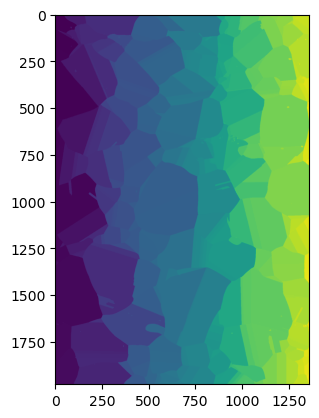

In [46]:
plt.imshow(m.get_grain_map())

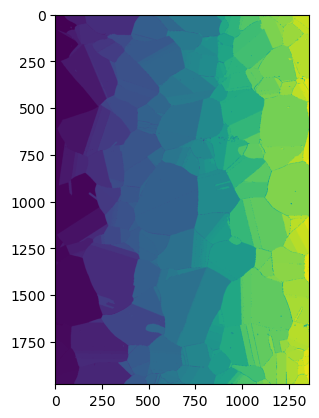

In [43]:
plt.imshow(m.get_grain_map())

In [36]:
import pymicro
from pymicro.crystal.microstructure import Orientation

In [10]:
from grains_merge import plot_grain_ids, get_cmap

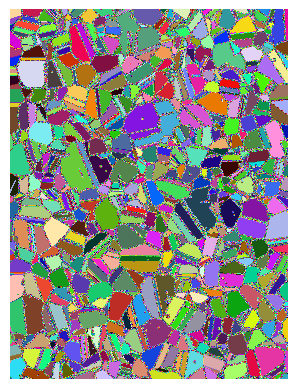

In [32]:
grain_ids = np.squeeze(np.load('data/grains_ids_maps/IN718_NEWTEC Nanoindentation 5min Nano-5m Site 1 Map Data 5_clean.npy'))
cmap = get_cmap(grain_ids)
im = plt.imshow(grain_ids, cmap=cmap)
plt.axis('off')
plt.savefig('original_grains.png')
plt.draw()

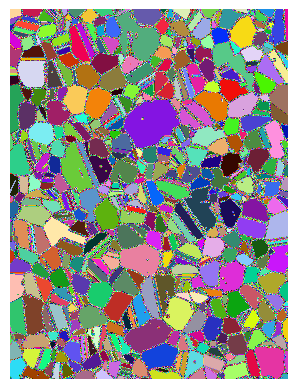

In [33]:
new_grain_ids = np.squeeze(np.load('data/grains_no_twins_ids_maps/IN718_NEWTEC Nanoindentation 5min Nano-5m Site 1 Map Data 5_clean.npy'))
cmap = get_cmap(new_grain_ids)
im = plt.imshow(new_grain_ids, cmap=cmap)
plt.axis('off')
plt.savefig('brandon_nu0_0_1_grains.png')
plt.draw()

In [ ]:
new_grain_ids

In [ ]:
m.get_grain(19).orientation.move_to_FZ()

In [ ]:
m.get_grain(19).orientation_matrix()